# Lab 10: Sentiment Analysis for Beer Reviews (1/2)


<img width=400 src="sentiments.png">

Sentiment analysis is the extraction of sentiment, which is the positive or negative orientation that an author of a text expresses towards an object. Typically, sentiment analysis systems do the following:
- Subjectivity classification: Is the text objective or subjective?
- Polarity classification: Is the expressed opinion positive, neutral or negative? How positive, neutral or negative is the text?
- Subject identification: Who/what is the target of the sentiment?

Sentiment analysis is one of the key areas of text data science that has found widespread interest in various fields like [politics](https://www.aaai.org/ocs/index.php/ICWSM/ICWSM10/paper/viewFile/1441/1852) (voter sentiment), [business](https://www.forbes.com/sites/jiawertz/2018/11/30/why-sentiment-analysis-could-be-your-best-kept-marketing-secret/#11d682642bbe) (product opinion mining), [finance](https://ieeexplore.ieee.org/document/7955659). These systems are either rule-based (with manually crafted rules) or machine learning based (to automatically learn relationships betweeen text and sentiment).

In this lab we will use a dataset of beer reviews to motivate sentiment analysis of product reviews. We will manually build our own sentiment lexicon to analyze sentiment by inspecting some positive and negative reviews, and we will also try using a general purpose sentiment [lexicon](https://www.cs.uic.edu/~liub/FBS/sentiment-analysis.html#lexicon). Finally, we will try automatically building the sentiment lexicon using the `Counter` class as before.

A good overview of sentiment analysis with useful links can be found [here](https://monkeylearn.com/sentiment-analysis/#sentiment-analysis-lexicons) or [here](https://www.sciencedirect.com/science/article/pii/S2090447914000550).

As always, load the usual modules.

In [1]:
from datascience import *
import numpy as np
import re
import gensim

from collections import Counter

import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)
logging.root.level = logging.CRITICAL 

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

# direct plots to appear within the cell, and set their style
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

## Load and Preprocess Dataset

The dataset we will use is of beer reviews. Each line of the dataset is a JSON object like so:

```
{"beer_brewerId": "8481", "review_time": "1157587200", "review_overall": "13/20", "review_text": "On tap at the Springfield, PA location. Poured a deep and cloudy orange (almost a copper) color with a small sized off white head. Aromas or oranges and all around citric. Tastes of oranges, light caramel and a very light grapefruit finish. I too would not believe the 80+ IBUs - I found this one to have a very light bitterness with a medium sweetness to it. Light lacing left on the glass.", "review_aroma": "6/10", "review_appearance": "4/5", "review_profileName": "hopdog", "beer_style": "India Pale Ale &#40;IPA&#41;", "review_palate": "3/5", "review_taste": "6/10", "beer_name": "John Harvards Simcoe IPA", "beer_ABV": "5.4", "beer_beerId": "63836"}
```

We will read and select 10000 of these objects (due to memory constraints).

In [2]:
# load file and build table
filename = "ratings.csv"
data = Table.read_table(filename)
sample_size = data.num_rows
data.show(2)

/Users/tanyichern/anaconda3/envs/171/lib/python3.6/site-packages/datascience/tables.py:132: FutureWarning: read_table is deprecated, use read_csv instead.
  df = pandas.read_table(filepath_or_buffer, *args, **vargs)


beer_ABV,beer_beerId,beer_brewerId,beer_name,beer_style,review_appearance,review_aroma,review_overall,review_palate,review_profileName,review_taste,review_text,review_time
5.4,63836,8481,John Harvards Simcoe IPA,India Pale Ale (IPA),4/5,6/10,13/20,3/5,hopdog,6/10,"On tap at the Springfield, PA location. Poured a deep an ...",1157587200
6.5,58511,3228,Barley Island Barfly IPA,India Pale Ale (IPA),3/5,5/10,8/20,2/5,jake65,4/10,"Bottle: Pours a murky caramel color with a modest, crea ...",1227744000


An example of a beer review is the following:

In [3]:
print(data.column('review_text')[1])

Bottle:  Pours a murky caramel color with a modest, creamy beige head.  Smells strong of floral hops, but also wheaty.  Maybe even a bit soapy?  Taste is rather dry and abrasive.  Florals, again soapy, and some wheat.  Hot and brash.  Plain and simple, I just didnt like it.


Currently, the review scores are strings like `"4/5"`. We want to transform these into integers like `4` so that processing will be easier later. This can be done by using regex to match until the `'/'`.

In [4]:
# transform columns with scoring into ints
review_cols = ["review_appearance", "review_aroma", "review_overall", "review_palate", "review_taste"]

def transform_int(score):
    return int(re.match(r'([0-9]*)\/', score)[1])

for col in review_cols:
    review_score = data.apply(transform_int, col)
    data = data.drop(col)
    data = data.with_column(col, review_score)

data.show(2)

beer_ABV,beer_beerId,beer_brewerId,beer_name,beer_style,review_profileName,review_text,review_time,review_appearance,review_aroma,review_overall,review_palate,review_taste
5.4,63836,8481,John Harvards Simcoe IPA,India Pale Ale (IPA),hopdog,"On tap at the Springfield, PA location. Poured a deep an ...",1157587200,4,6,13,3,6
6.5,58511,3228,Barley Island Barfly IPA,India Pale Ale (IPA),jake65,"Bottle: Pours a murky caramel color with a modest, crea ...",1227744000,3,5,8,2,4


Let's see the distribution of overall review scores.

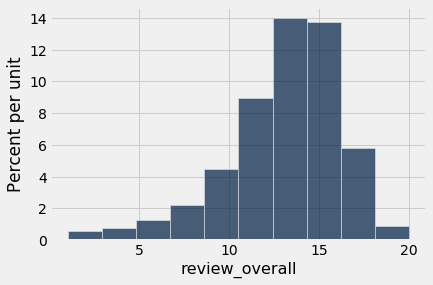

In [5]:
data.hist("review_overall")

We shall label the reviews into 3 classes: positive, neutral and negative. To simplify matters, we will sort the reviews in increasing order of overall review score. The first third will be labelled negative, the next third neutral, and the last third positive.

In [6]:
# sort by increasing review overall score
data = data.sort("review_overall")

# label class
c2i = {"negative": 1,
       "neutral": 2,
       "positive": 3}
labels = [c2i["negative"]] * int(sample_size/3)
labels.extend([c2i["neutral"]] * int(sample_size/3))
labels.extend([c2i["positive"]] * (int(sample_size/3)+1))

# add to data
data = data.with_column("class", labels)
data.show(2)

beer_ABV,beer_beerId,beer_brewerId,beer_name,beer_style,review_profileName,review_text,review_time,review_appearance,review_aroma,review_overall,review_palate,review_taste,class
5,51707,156,Lakefront New Grist Sorghum Beer,Specialty Grain,roder60,Poured a very light offwhite offyellow color with almost ...,1193875200,1,2,1,1,2,1
5,44918,49,Molson Kick,Spice/Herb/Vegetable,Kinger,"UPDATED: JAN 2, 2006 Bottle. I cant believe I was into t ...",1135987200,1,1,1,1,1,1


In the subsequent sections, we will develop different models for scoring the sentiment of a beer review. To do so, we will split the dataset into a training set (80%) and a test set (20%). The training set will be used to develop the model, while the test set will be used to evaluate the model. This allows us to evaluate the model in a manner that is independent from how it was developed. 

We also treat the problem of scoring the sentiment of beer review text (`x_test`) in two ways:
- Continuous score: Our models will output a sentiment score. We treat the provided overall review score (`scores_train`) as the gold standard metric of the review sentiment. The correlation of these two types of scores will indicate how well the model's predicted sentiment follows the actual sentiment.

- Discrete class: Using the predicted sentiment score, we will classify the review into negative, neutral and positive. We treat the labelled actual classes (`y_test`) as the gold standard class of the review. The accuracy of the predicted classes matching the actual classes also indicates model performance.

In [7]:
# split to training and test set
from sklearn.model_selection import train_test_split
seed = 123

train, test = train_test_split(data.to_df(), test_size=0.20, random_state=seed)
train = Table.from_df(train)
test = Table.from_df(test)

x_train = train.column("review_text")
y_train = train.column("class")
scores_train = train.column("review_overall")

x_test = test.column("review_text")
y_test = test.column("class")
scores_test = test.column("review_overall")

## Manually Created Sentiment Lexicon

In the rest of this lab, we will explore rule-based approaches to sentiment analysis. We are concerned with different ways of building a sentiment lexicon, which is a dictionary of positive and negative words.

To manually construct this, we can explore a few of the negative and positive reviews and pick out words, for the respective lexicon, that stand out as indicative of either negative or positive sentiment.

In [8]:
# explore negative reviews 
data_neg = train.where("class", c2i["negative"])
samples_neg = data_neg.sample(k=3,  with_replacement=False)
texts_neg = samples_neg.column("review_text")
scores_neg = samples_neg.column("review_overall")

print("Negative reviews")
for text, score in zip(texts_neg, scores_neg):
    print("(%d): %s" % (score, text), "\n")
    
# explore neutral reviews 
data_neu = train.where("class", c2i["neutral"])
samples_neu = data_neu.sample(k=3,  with_replacement=False)
texts_neu = samples_neu.column("review_text")
scores_neu = samples_neu.column("review_overall")

print("Neutral reviews")
for text, score in zip(texts_neu, scores_neu):
    print("(%d): %s" % (score, text), "\n")
    
# explore positive reviews 
data_pos = train.where("class", c2i["positive"])
samples_pos = data_pos.sample(k=3,  with_replacement=False)
texts_pos = samples_pos.column("review_text")
scores_pos = samples_pos.column("review_overall")

print("Positive reviews")
for text, score in zip(texts_pos, scores_pos):
    print("(%d): %s" % (score, text), "\n")

Negative reviews
(12): Bottle from Quack-Duck. Blonde. Floral maltaroma with hints of boiled milk. Hay-like hopbitter flavor. Almost oily bitter aftertaste. Loads of flavor in this helles. 

(9): Tasting from May 2009.  Out the bottle, cool but not chilled. Auburn amber body and not quite bright (odd!?). A few disagreeably big bubbles cling to the base of the pint, otherwise its sparsely carbonated. A creamy but flaccid off white pad forms atop and manages to stick around for the length. Not much legs remain. Mildly sherryish, sulphury and toffee fueled nose with licks of fresh baked bread coming through. Sweet on first sip with a rough, weedy bitter bite in back. A little tannic rust makes an unpleasant appearance and what seems like watered down red grape juice. Toffee and powdery, smoky black malt a highlight but even this fades under a watery, thin palate. Very weedy aftertaste lingers too long. More hop than malt but not working in its favour. A bit all over the show to be pleasin

Based on the words we identified from the samples of negative and positive reviews, we build the positive and negative sentiment lexicons as sets of words (effectively, vocabularies).

In [9]:
# build negative and positive lexicon     
neg_lex = {"bizarre", "rotten", "horrible", "bad", "terrible", 
           "bland", "unpleasant", "boring", "worse", "ew", 
           "disgusting"}

pos_lex = {"sweet", "beautiful",  "wonderful", "smooth", "enjoyable", 
           "correct", "drinkable", "recommended", "good", "refreshing",
           "incredible"}

Recall that in lab06 we relied on the following functions to process our text strings, removing any tokens with numerics, possessives, or empty strings. These functions also apply here in removing tokens that we do not want to consider in our scoring.

Our scoring procedure is simply the following: +1 for a token in a positive lexicon, and -1 for a token in a negative lexicon. Then, a document has positive sentiment if its overall score is above 0, a negative sentiment if its overall score is below 0, and a neutral sentiment if its overall score is 0. This is a **bag of words** approach to sentiment analysis, where we treat each token in the review as an individual atomic unit. Can you think of problems with this approach?

In [10]:
# simple scoring function and auxiliary functions    
def is_numeric(string):
    return any(char.isdigit() for char in string)

def has_poss_contr(string):
    return '\'s' in string

def empty_string(string):
    return not string

def remove_string(string):
    return is_numeric(string) or has_poss_contr(string) or empty_string(string)

def score(text):
    text = re.sub(r'[^\w\s]', '', text)
    tokens = text.lower().strip().split(' ')
    tokens = [token for token in tokens if not remove_string(token)]

    score = 0
    for token in tokens:
        if token in neg_lex:
            score -= 1
        elif token in pos_lex:
            score += 1
    return score

def classify(score):
    if score < 0:
        return 1
    elif score == 0:
        return 2
    else:
        return 3

Given the above sentiment lexicons and procedure described, we then score all beer reviews in the test set. Using the predicted scores, we also classify each beer review into a class of positive, neutral or negative sentiment.

To evaluate the model, we compute the following:
- Correlation coefficient: a numerical measure of the relationship between two variables. A higher value indicates a stronger correlation. To visualize this, we also plot a scatterplot.
- Accuracy: the % accuracy of the model in predicting the class of a sentiment. 

Correlation coefficient: 0.228099
Classification accuracy: 0.367500


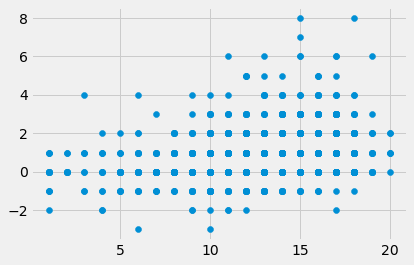

In [11]:
# score test set
pred_scores = [score(text) for text in x_test]
pred_class = [classify(score) for score in pred_scores]

# correlation (for scores), accuracy (for class)
corr = np.corrcoef(scores_test, pred_scores)[0,1]
acc = np.mean(np.equal(y_test, pred_class))
print("Correlation coefficient: %f" % corr)
print("Classification accuracy: %f" % acc)

# scatterplot
plt.scatter(scores_test, pred_scores)
plt.show()

The model performs slightly better than chance (36.8% compared to 33.3%), and has a weak correlation coefficient. How can we do better?

### Your turn!

Using the procedure above, expand the negative and positive lexicons by manually adding in 5 words *each*, which correspond to a negative and positive sentiment respectively. 

To do so, you should sample negative, neutral and positive reviews as above, and then pick out words that you think uniquely represent the corresponding sentiment. Show your results in terms of correlation coefficieent and classification accuracy.

How much improvement are you able to attain?

## General Purpose Sentiment Lexicon


Now, instead of manually building our sentiment lexicon, we shall adopt a general purpose sentiment lexicon created by Hu and Liu. This lexicon was specifically [created](https://www.cs.uic.edu/~liub/publications/kdd04-revSummary.pdf) to handle customer reviews, so we expect performance of our model to increase. 

In [12]:
# !unzip opinion-lexicon-English.zip

def load_lexicon(filename):
    """
    Load a file from Bing Liu's sentiment lexicon
    (https://www.cs.uic.edu/~liub/FBS/sentiment-analysis.html#lexicon), containing
    English words in Latin-1 encoding.
    
    One file contains a list of positive words, and the other contains
    a list of negative words. The files contain comment lines starting
    with ';' and blank lines, which should be skipped.
    
    With thanks to Robyn Speer (http://blog.conceptnet.io/posts/2017/how-to-make-a-racist-ai-without-really-trying/)
    """
    lexicon = []
    with open(filename, encoding='latin-1') as infile:
        for line in infile:
            line = line.rstrip()
            if line and not line.startswith(';'):
                lexicon.append(line)
    return lexicon

pos_lex = set(load_lexicon('opinion-lexicon-English/positive-words.txt'))
neg_lex = set(load_lexicon('opinion-lexicon-English/negative-words.txt'))

As before, evaluate this model built on the general purpose sentiment lexicon by calculating the correlation coefficieent and classification accuracy on the test set.

Correlation coefficient: 0.302706
Classification accuracy: 0.386500


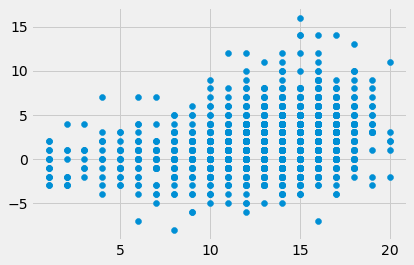

In [13]:
# score test set
pred_scores = [score(text) for text in x_test]
pred_class = [classify(score) for score in pred_scores]

# correlation (for scores), accuracy (for class)
corr = np.corrcoef(scores_test, pred_scores)[0,1]
acc = np.mean(np.equal(y_test, pred_class))
print("Correlation coefficient: %f" % corr)
print("Classification accuracy: %f" % acc)

# scatterplot
plt.scatter(scores_test, pred_scores)
plt.show()

We achieve only slightly better correlation and classification accuracy. The lesson here is that sentiment lexicons created in a general purpose manner tend not to generalize well to domain specific datasets. Intuitively, beer reviews contain tokens that carry positive and negative sentiment specific to the domain of rating beer.

## Automatically Created Sentiment Lexicon

Now, we will automatically create our sentiment lexicons by building a pos/neg dictionary of words over the positive beer reviews and negative beer reviews respectively. Take note that we should only do this over the training set! **Why?** 

Using previous techniques (the `Counter` class), we can easily build this lexicon. Since the positive and negative lexicons are likely to contain many common words, we only want to count words that do not appear in both lexicons in the respective positive / negative lexicon.

In [14]:
# build negative lexicon
texts_neg = train.where("class", c2i["negative"]).column("review_text")
vocab_neg = Counter()
texts_neg_tok = [text.lower().strip().split(' ') for text in texts_neg]
texts_neg_tok = [[token for token in text if not remove_string(token)] for text in texts_neg_tok]
for text in texts_neg_tok:
    vocab_neg.update(text)
neg_lex = set(vocab_neg)

# build positive lexicon
texts_pos = train.where("class", c2i["positive"]).column("review_text")
vocab_pos = Counter()
texts_pos_tok = [text.lower().strip().split(' ') for text in texts_pos]
texts_pos_tok = [[token for token in text if not remove_string(token)] for text in texts_pos_tok]
for text in texts_pos_tok:
    vocab_pos.update(text)
pos_lex = set(vocab_pos)

intersect = neg_lex.intersection(pos_lex)
neg_lex = neg_lex - intersect
pos_lex = pos_lex - intersect

Correlation coefficient: 0.231229
Classification accuracy: 0.410000


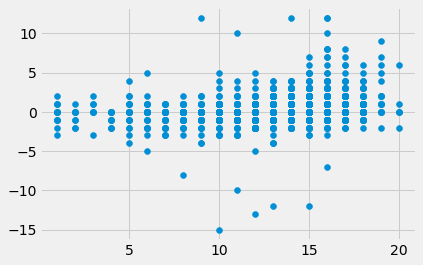

In [15]:
# score test set
pred_scores = [score(text) for text in x_test]
pred_class = [classify(score) for score in pred_scores]

# correlation (for scores), accuracy (for class)
corr = np.corrcoef(scores_test, pred_scores)[0,1]
acc = np.mean(np.equal(y_test, pred_class))
print("Correlation coefficient: %f" % corr)
print("Classification accuracy: %f" % acc)

# scatterplot
plt.scatter(scores_test, pred_scores)
plt.show()

Our performance is the best yet! This is not too surprising, since this method manages to capture the domain specific semantics for rating beer in a positive or negative manner.

### Your turn!

Currently, we build both sentiment lexicons over the full training data. How does model performance change when we only use a smaller subset of the training data?

Analyze how the performance of this model (automatically constructing the negative and positive lexicon) varies as you change the size of training set over which to build the lexicons. Make sure your size range is between 800 to 8000 inclusive! 

Discuss and suggest reasons for the observed trend.

You can use the following to get started:

```
def build_lexicons(train, c2i, size):
    
    # sample train set
    subset = train.sample(size, with_replacement=False)
    
    # build negative lexicon
    
    # build positive lexicon
    
    # return lexicons
    
# define step size and list of sizes to use

# for each size

    # build lexicons
    
    # obtain predicted scores and classes
    
    # compute correlation coefficient and accuracy
    
# plot the correlation and accuracy, against sizes, on same graph
```